## Functional API for Image Classification

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import autokeras as ak
from tensorflow.keras import layers, models, datasets
tf.random.set_seed(42)

In [2]:
# This fix an issue with TensorFlow 2.4.1 reported here https://github.com/tensorflow/tensorflow/issues/43174
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Load the dataset

Download the CIFAR1O dataset.
The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

Verify some images

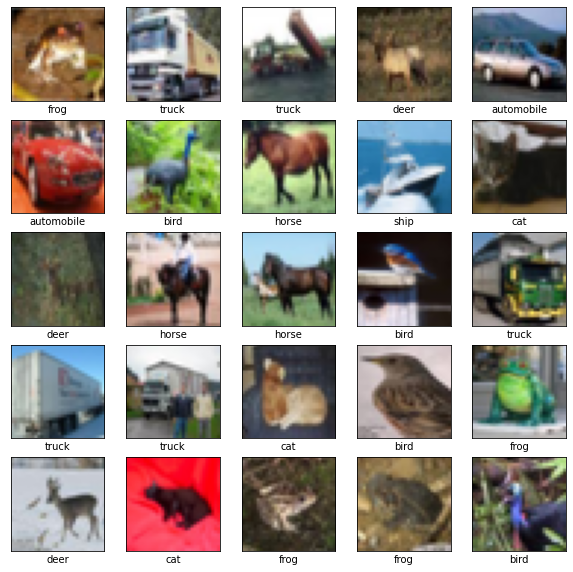

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

## Build the automated image classification using AutoKeras Functional API.

We can use the AutoModel API that works like the Keras functional API.
Whild building the model, the blocks used need to follow this topology: `Preprocessor` -> `Block` -> `Head`. `Normalization` and `ImageAugmentation` are Preprocessors. `ClassificationHead` is Head. The rest are Blocks.

In [12]:
# Build the custom model
input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node1 = ak.ConvBlock()(output_node)
output_node2 = ak.ResNetBlock(version="v2")(output_node)
output_node = ak.Merge()([output_node1, output_node2])
output_node = ak.ClassificationHead(num_classes=10)(output_node)

In [18]:
auto_model = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
    max_trials=10,
    #trials=3,
    )

In [19]:
# Feed the AutoModel with training data.
auto_model.fit(x_train[:10000], y_train[:10000], epochs=10)

Trial 10 Complete [00h 05m 06s]
val_loss: 1.7498449087142944

Best val_loss So Far: 1.7498449087142944
Total elapsed time: 00h 42m 23s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
313/313 [==============================] - 37s 89ms/step - loss: 2.2805 - accuracy: 0.1438
Epoch 2/10
313/313 [==============================] - 28s 88ms/step - loss: 1.9092 - accuracy: 0.3281
Epoch 3/10
313/313 [==============================] - 28s 89ms/step - loss: 1.7184 - accuracy: 0.4118
Epoch 4/10
313/313 [==============================] - 28s 88ms/step - loss: 1.5480 - accuracy: 0.4821
Epoch 5/10
313/313 [==============================] - 28s 88ms/step - loss: 1.3644 - accuracy: 0.5649
Epoch 6/10
313/313 [==============================] - 28s 88ms/step - loss: 1.1409 - accuracy: 0.6806
Epoch 7/10
313/313 [==============================] - 28s 89ms/step - loss: 0.8499 - accuracy: 0.8135
Epoch 8/10
313/313 [==============================] - 28s 89ms/step - loss: 0.4892 - accuracy: 0.9386
Epoch 9/10


In [22]:
# Get the summirized results
auto_model.tuner.results_summary()

Results summary
Results in .\auto_model
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
conv_block_1/kernel_size: 3
conv_block_1/separable: False
conv_block_1/max_pooling: True
conv_block_1/dropout: 0
conv_block_1/num_blocks: 2
conv_block_1/num_layers: 2
conv_block_1/filters_0_0: 512
conv_block_1/filters_0_1: 32
conv_block_1/filters_1_0: 64
conv_block_1/filters_1_1: 512
res_net_block_1/pretrained: False
res_net_block_1/version: resnet101_v2
res_net_block_1/imagenet_size: False
classification_head_1/dropout: 0.0
optimizer: adam
learning_rate: 1e-05
conv_block_1/filters_2_0: 128
conv_block_1/filters_2_1: 32
Score: 1.7498449087142944
Trial summary
Hyperparameters:
conv_block_1/kernel_size: 3
conv_block_1/separable: False
conv_block_1/max_pooling: True
conv_block_1/dropout: 0
conv_block_1/num_blocks: 2
conv_block_1/num_layers: 2
conv_block_1/filters_0_0: 512
conv_block_1/filters_0_1: 32
conv_block_1/filters_1_0: 64
conv_block_1/filters_1_1:

In [23]:
# Get the best model
best_model = auto_model.export_model()
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 32, 32, 3)    7           cast_to_float32[0][0]            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 30, 512)  14336       normalization[0][0]              
______________________________________________________________________________________________

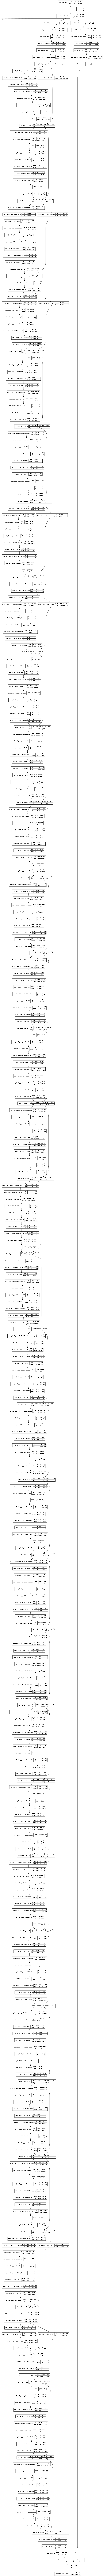

In [25]:
# Get the model image
tf.keras.utils.plot_model(best_model, to_file='model.png', show_shapes=True, expand_nested=True,dpi=64)

In [29]:
# compile the model and train the model
best_model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

In [30]:
## Retrain the best model using the whole training set
best_model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 80s 108ms/step - loss: 1.9084 - accuracy: 0.3932 - val_loss: 1.1591 - val_accuracy: 0.6018
Epoch 2/10
625/625 [==============================] - 67s 107ms/step - loss: 1.1114 - accuracy: 0.6325 - val_loss: 20.3129 - val_accuracy: 0.6257
Epoch 3/10
625/625 [==============================] - 66s 105ms/step - loss: 0.8795 - accuracy: 0.7048 - val_loss: 9.5700 - val_accuracy: 0.5893
Epoch 4/10
625/625 [==============================] - 66s 105ms/step - loss: 0.6904 - accuracy: 0.7690 - val_loss: 6.9710 - val_accuracy: 0.6568
Epoch 5/10
625/625 [==============================] - 61s 97ms/step - loss: 0.5326 - accuracy: 0.8237 - val_loss: 1.3640 - val_accuracy: 0.7023
Epoch 6/10
625/625 [==============================] - 64s 103ms/step - loss: 0.3523 - accuracy: 0.8806 - val_loss: 1.0763 - val_accuracy: 0.7005
Epoch 7/10
625/625 [==============================] - 61s 97ms/step - loss: 0.2464 - accuracy: 0.9160 - val_loss: 1.2833 - val_acc

## Predict the model

In [31]:
# Predict with the best model, the class of the test image
predicted_y = best_model.predict(x_test[:32]).argmax(axis=1)

## Evaluate the model

In [32]:
# Evaluate the best model with testing data.
loss, acc = best_model.evaluate(x_test, y_test)
print(f"Test loss: {loss}, test acc: {acc}")

313/313 [==============================] - 10s 33ms/step - loss: 1.8375 - accuracy: 0.6894
Test loss: 1.8375369310379028, test acc: 0.6894000172615051


### Show predicted results

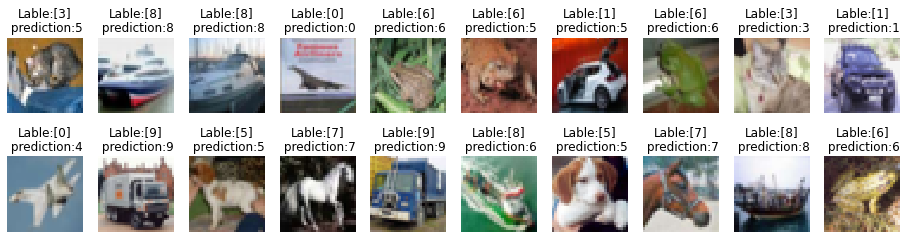

In [33]:
# make prediction and plot the results
y_predictions = best_model.predict( x_test[:32] ).argmax(axis = 1)

plt.figure( figsize=(16,4) )
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(x_test[i].reshape(32,32,3), cmap='gray', interpolation='none')
    plt.title("Lable:{}\n prediction:{}".format(y_test[i], y_predictions[i]))
    plt.axis('off')